<a href="https://colab.research.google.com/github/VerebicsPeter/CodeSim/blob/main/model/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Similarity with Contrastive Learning

## Dependencies

In [1]:
!pip install python-minifier  # for data augmentation
!pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 3.6 MB/s eta 0:00:00


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint as pp
import random
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.utils.tensorboard import SummaryWriter
from pytorch_metric_learning import losses
# Hugging Face Transformers (CodeBERT etc.)
import transformers
from transformers import AutoTokenizer, AutoModel
# Libraries for augmenting data
import python_minifier
# Libraries for logging
from tqdm.auto import tqdm
from typing import Iterable, Callable

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Seeding

In [ ]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(seed_value=42)

## Dataset Access

In [ ]:
labeled_dataset_url = "https://drive.google.com/uc?export=download&id=1UteITBYXcBLt2hXviy71jQr-oXceVcs5}"
unlabeled_dataset_url = "https://drive.google.com/uc?export=download&id=1iHHgOcJQ_qp3sk3d7w1zpWBvsgDqrPJV}"

## Dataset and Data Augmentation

In [8]:
# Code datasets (for labeled and unlabeled code snippets)


def augment(df: pd.DataFrame, *functions):
    """Calculates data augmentations on a CodeNet sampled dataframe with labeled source code."""
    # Dataframe to augment (dataframe containing passing CodeNet examples)
    to_aug = df[df['label'].apply(lambda label: label.endswith('1'))]
    augs = []
    for function in functions:
        aug = to_aug.copy()
        aug.loc[:, 'source'] = aug['source'].apply(function)
        augs.append(aug)
    df = pd.concat([df, *augs], ignore_index=True)
    # Sort the dataframe so matching labels are next to eachother.
    df.sort_values(by='label', inplace=True)
    return df


def numeric_labels(labels: Iterable[str]) -> torch.Tensor:
    """Transform string labels to int labels for the NTXent loss function."""
    pos_labels = [ label for label in labels if label.endswith('1') ]
    labels_map = { label: i for i,label in enumerate(sorted(set(pos_labels))) }
    int_labels = [ labels_map.get(label, -1) for label in labels ]
    int_labels = torch.Tensor(int_labels)
    neg_indices = (int_labels == -1).nonzero(as_tuple=True)[0]
    M = max(int_labels)
    int_labels[neg_indices] = torch.arange(M + 1, M + 1 + len(neg_indices))
    return int_labels


def get_batch_encodings(
    codes: Iterable[str],
    tokenizer: transformers.PreTrainedTokenizer | transformers.PreTrainedTokenizerFast,
    device: str = "cpu"
) -> transformers.BatchEncoding:
    MAX_LEN = tokenizer.model_max_length

    inputs = tokenizer(
        codes,
        truncation=True,
        # Pad to "MAX_LEN + 1" to detect sequences that are too long
        padding="max_length", max_length=MAX_LEN + 1,
        return_tensors="pt",
    )

    # Mask sequences that are longer than "MAX_LEN"
    l_mask = inputs["attention_mask"].sum(dim=1) <= MAX_LEN

    inputs = { k: v[l_mask, :MAX_LEN] for k, v in inputs.items() }
    # Move tensors to the specified device
    inputs = { k: v.to(device) for k, v in inputs.items() }

    return inputs


class LabeledCodeDataset(Dataset):
    def __init__(
        self,
        tokenizer: transformers.PreTrainedTokenizer | transformers.PreTrainedTokenizerFast,
        codes : Iterable[str],
        labels: Iterable[str]
    ):
        assert len(codes) == len(labels)
        self.inputs = get_batch_encodings(codes, tokenizer, device)
        self.labels = numeric_labels(labels)

    def __getitem__(self, idx):
        input = {k: v[idx] for k, v in self.inputs.items()}
        label = self.labels[idx]
        return input, label

    def __len__(self):
        return self.inputs['input_ids'].shape[0]

    @classmethod
    def from_csv_data(cls, path: str, tokenizer, aug_funcs: Iterable[Callable]):
        df = pd.read_csv(path)
        print(df.shape)

        if aug_funcs:
            print('augmenting data (this might take a while) ...')
            codes = augment(df, *aug_funcs)
            print(codes.shape)

        codes = df['source']
        codes = codes.to_list()

        labels = df['label']
        labels = labels.to_list()

        return cls(tokenizer, codes, labels)


class UnlabeledCodeDataset(Dataset):
    def __init__(
        self,
        tokenizer: transformers.PreTrainedTokenizer | transformers.PreTrainedTokenizerFast,
        ref_codes: Iterable[str],
        aug_codes: Iterable[str],
    ):
        assert len(ref_codes) == len(aug_codes)
        self.ref_inputs = get_batch_encodings(ref_codes, tokenizer, device)
        self.aug_inputs = get_batch_encodings(aug_codes, tokenizer, device)

    def __getitem__(self, idx):
        # Return both reference and augmented code inputs for a given index
        ref_input = {k: v[idx] for k, v in self.ref_inputs.items()}
        aug_input = {k: v[idx] for k, v in self.aug_inputs.items()}
        return ref_input, aug_input

    def __len__(self):
        return self.ref_inputs["input_ids"].shape[0]

    @classmethod
    def from_csv_data(cls, path: str, tokenizer, aug_funcs: Iterable[Callable]):
        df = pd.read_csv(path)
        print(df.shape)

        ref_codes = df['file_content']
        ref_codes = ref_codes.to_list()

        aug_codes = df['file_content'].apply(aug_funcs[0])
        aug_codes = aug_codes.to_list()
        # TODO: multiple augmentations

        return cls(tokenizer, ref_codes, aug_codes)

In [9]:
# Data augmentaion functions

def minify(code: str) -> str:
    try: return python_minifier.minify(code)
    except Exception as error:
        print(f'Error while minifying: {error}')  # TODO: use a log file for this
    return code

## Model

In [10]:
# Model


IS_SELF_SUPERVISED = False


def embedding_pipeline(transformer):
    """Create an embedding function with a `tokenizer` and `transformer`."""
    def pipeline(inputs: transformers.BatchEncoding):
        with torch.device(device):
            return transformer(**inputs)
    return pipeline


class CodeSimilarityModel(nn.Module):
    def __init__(self,
        embedding_pipeline,
        in_feat=768,  # depends on the embedding pipeline
        mlp_sizes=(512, 256, 128),
        out_feat=32,
        dropout_rate=0.2,
    ):
        super().__init__()
        self.embedding_pipeline = embedding_pipeline

        # Non linearity
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)

        assert len(mlp_sizes) == 3, 'MLP must have 3 hidden sizes'

        # MLP 'projection head'
        mlp_layers = []
        mlp_layers.append(nn.Linear(in_feat, mlp_sizes[0]))

        mlp_layers.extend([self.relu, self.drop])
        mlp_layers.append(nn.Linear(mlp_sizes[0], mlp_sizes[1]))

        mlp_layers.extend([self.relu, self.drop])
        mlp_layers.append(nn.Linear(mlp_sizes[1], mlp_sizes[2]))

        mlp_layers.extend([self.relu, self.drop])
        mlp_layers.append(nn.Linear(mlp_sizes[2], out_feat))

        self.mlp = nn.Sequential(*mlp_layers)


    def embed(self, inputs: transformers.BatchEncoding) -> torch.Tensor:
        output = self.embedding_pipeline(inputs)
        return output.pooler_output

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.device(device):
            # pass through linear layers
            x = self.mlp(x)
            return x

## NTXent Loss Function

In [11]:
ntxent_loss = losses.NTXentLoss(temperature=0.5)
# Wrap the NTXent loss function if needed
ntxent_loss = losses.SelfSupervisedLoss(ntxent_loss) if IS_SELF_SUPERVISED else ntxent_loss

## Training Loop

In [13]:
# Training loop for the NTXEnt loss function

def compute_loss(batched_data, model, loss_func):
    """Computes the loss value for a batch of data."""
    if isinstance(loss_func, losses.SelfSupervisedLoss):
        ref_input, aug_input = batched_data
        ref_emb = model.embed(ref_input)  # transformer
        aug_emb = model.embed(aug_input)  # transformer
        ref_emb = model(ref_emb)  # MLP
        aug_emb = model(aug_emb)  # MLP
        loss = loss_func(ref_emb, aug_emb)
        return loss
    else:
        inputs, labels = batched_data
        embeddings = model.embed(inputs)  # transformer
        embeddings = model(embeddings)  # MLP
        loss = loss_func(embeddings, labels)
        return loss


def train_epoch(
    model: CodeSimilarityModel,
    loader: DataLoader,
    loss_func,
    optimizer,
    epochs: int = 0,  # number of epochs so far (for logging)
    writer: SummaryWriter | None = None,  # for logging loss values
):
    """Trains the model for one epoch."""

    def get_last_loss(n_batches, c_batches, batch, acc_loss):
        if batch % c_batches == c_batches - 1:
            return 0, acc_loss / c_batches
        elif batch == N_BATCHES - 1:
            return 0, acc_loss / (n_batches % c_batches)
        return acc_loss, 0

    def write_loss(writer, n_batches, batch, last_loss):
        # Log the average loss over the last  batches
        # TODO: use a log file for this
        print('',f'Batch: {batch + 1}/{n_batches}, Loss: {last_loss}')
        if writer is not None:
            writer.add_scalar("loss/train", last_loss, epochs * n_batches + batch + 1)

    model.train()  # Set the model to training mode
    N_BATCHES = len(loader)  # Number of batches
    C_BATCHES = 50  # Number of batches over which the logged loss is cumulated
    sum_loss = 0  # Loss accumulated per EPOCH
    acc_loss = 0  # Loss accumulated per last 25 batches
    progress_bar = tqdm(range(N_BATCHES))
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        loss = compute_loss(data, model, loss_func)
        # Adjust the weights
        loss.backward()
        optimizer.step()
        # Increase loss accumulator
        loss_val = loss.item()
        acc_loss += loss_val; sum_loss += loss_val
        # Update the loss accumulator and log the last loss
        progress_bar.update(1)
        acc_loss, last_loss = get_last_loss(N_BATCHES, C_BATCHES, i, acc_loss)
        if last_loss: write_loss(writer, N_BATCHES, i, last_loss)
    # Return the average loss in the epoch
    avg_loss = sum_loss / N_BATCHES
    return avg_loss


def validate(
    model: CodeSimilarityModel,
    loader: DataLoader,
    loss_func,
):
    """Validates the model for one epoch."""
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        sum_loss = 0
        for data in loader:
            loss = compute_loss(data, model, loss_func)
            sum_loss += loss.item()
        avg_loss = sum_loss / len(loader)
        return avg_loss


def train(
    model: CodeSimilarityModel,
    dataloaders,
    loss_func,
    optimizer,
    scheduler,
    epochs: int = 5,
):
    writer = None #SummaryWriter()
    tLosses, vLosses = [], []
    training_loader, validation_loader = dataloaders
    for epoch in range(epochs):
        print(f'EPOCH {epoch + 1}/{epochs}')
        # Train then validate
        avg_tLoss = train_epoch(model, training_loader, loss_func, optimizer, epoch, writer)
        avg_vLoss = validate(model, validation_loader, loss_func)
        # Adjust the LR scheduler
        if scheduler is not None:
            scheduler.step()
        # Log the losses
        print(f"EPOCH {epoch + 1}/{epochs}, AVG loss: {avg_tLoss}, AVG validation loss: {avg_vLoss}")
        tLosses.append(avg_tLoss)
        vLosses.append(avg_vLoss)
    if writer is not None:
        writer.close()
    return tLosses, vLosses

## Training

In [14]:
PRETRAINED_MODEL="huggingface/CodeBERTa-small-v1"

"""
Other models:
 "microsoft/codebert-base"
 "neulab/codebert-python"
"""

# Tokenizer is created first for preprocessing
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/994k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/483k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
# Create the dataset

if IS_SELF_SUPERVISED:
    dataset = UnlabeledCodeDataset.from_csv_data(
        path= unlabeled_dataset_url,
        tokenizer=tokenizer,
        aug_funcs=[minify]
    )
else:
    dataset = LabeledCodeDataset.from_csv_data(
        path= labeled_dataset_url,
        tokenizer=tokenizer,
        aug_funcs=[minify]
    )

(34806, 3)
augmenting data (this might take a while) ...
Error while minifying: Missing parentheses in call to 'print'. Did you mean print(...)? (python_minifier.minify source, line 41)
Error while minifying: Missing parentheses in call to 'print'. Did you mean print(...)? (python_minifier.minify source, line 19)
Error while minifying: Missing parentheses in call to 'print'. Did you mean print(...)? (python_minifier.minify source, line 19)
Error while minifying: Missing parentheses in call to 'print'. Did you mean print(...)? (python_minifier.minify source, line 3)
Error while minifying: Missing parentheses in call to 'print'. Did you mean print(...)? (python_minifier.minify source, line 7)
Error while minifying: Missing parentheses in call to 'print'. Did you mean print(...)? (python_minifier.minify source, line 29)
Error while minifying: inconsistent use of tabs and spaces in indentation (python_minifier.minify source, line 10)
Error while minifying: Missing parentheses in call to 'p

In [24]:
SAMPLE_SIZE = 25_000
dataset = Subset(dataset, list(range(SAMPLE_SIZE)))

In [25]:
# Split the data
tsize = int(0.8 * len(dataset))
vsize = len(dataset) - tsize
training_data, validation_data = random_split(dataset, [tsize, vsize])

In [26]:
# Create the data loaders

# NOTE: Bigger batch size generally leads to better results in contrastive learning
BATCH_SIZE = 20
SHUFFLE = False

training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
validation_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [27]:
# Create embedding pipeline, model, optimizer and scheduler

transformer = AutoModel.from_pretrained(PRETRAINED_MODEL).to(device)
transformer.eval()

emb_pipeline = embedding_pipeline(transformer)

model = CodeSimilarityModel(emb_pipeline).to(device)
m_optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
m_scheduler = torch.optim.lr_scheduler.StepLR(m_optimizer, step_size=4, gamma=0.1)

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

In [28]:
# Train the model
losses = train(
    model,
    dataloaders=(training_loader, validation_loader),
    loss_func=ntxent_loss,
    optimizer=m_optimizer,
    scheduler=m_scheduler,
    epochs=4
)

EPOCH 1/4


  0%|          | 0/1000 [00:00<?, ?it/s]

 Batch: 50/1000, Loss: 1.3507464694976807
 Batch: 100/1000, Loss: 1.6399417543411254
 Batch: 150/1000, Loss: 1.5289570379257202
 Batch: 200/1000, Loss: 1.7091013860702515
 Batch: 250/1000, Loss: 1.228144073486328
 Batch: 300/1000, Loss: 1.527280650138855
 Batch: 350/1000, Loss: 2.0019309234619143
 Batch: 400/1000, Loss: 1.2345435285568238
 Batch: 450/1000, Loss: 1.5808808946609496
 Batch: 500/1000, Loss: 1.4112619256973267
 Batch: 550/1000, Loss: 1.3541012334823608
 Batch: 600/1000, Loss: 1.1800273323059083
 Batch: 650/1000, Loss: 1.523805823326111
 Batch: 700/1000, Loss: 1.5257694053649902
 Batch: 750/1000, Loss: 1.6499506473541259
 Batch: 800/1000, Loss: 1.4721503686904907
 Batch: 850/1000, Loss: 1.3506958389282226
 Batch: 900/1000, Loss: 1.3540926265716553
 Batch: 950/1000, Loss: 2.0498117876052855
 Batch: 1000/1000, Loss: 1.8212438249588012
EPOCH 1/4, AVG loss: 1.5247218766212463, AVG validation loss: 1.4427183742523193
EPOCH 2/4


  0%|          | 0/1000 [00:00<?, ?it/s]

 Batch: 50/1000, Loss: 1.3571345329284668
 Batch: 100/1000, Loss: 1.6357153367996216
 Batch: 150/1000, Loss: 1.526427230834961
 Batch: 200/1000, Loss: 1.7114148187637328
 Batch: 250/1000, Loss: 1.2422098731994629
 Batch: 300/1000, Loss: 1.5245299959182739
 Batch: 350/1000, Loss: 1.9972561979293824
 Batch: 400/1000, Loss: 1.230945110321045
 Batch: 450/1000, Loss: 1.5906277465820313
 Batch: 500/1000, Loss: 1.408669376373291
 Batch: 550/1000, Loss: 1.358708462715149
 Batch: 600/1000, Loss: 1.1679071044921876
 Batch: 650/1000, Loss: 1.5192785549163819
 Batch: 700/1000, Loss: 1.5253856372833252
 Batch: 750/1000, Loss: 1.6407884311676026
 Batch: 800/1000, Loss: 1.4761964082717896
 Batch: 850/1000, Loss: 1.3468718767166137
 Batch: 900/1000, Loss: 1.349319715499878
 Batch: 950/1000, Loss: 2.0371814823150634
 Batch: 1000/1000, Loss: 1.812922010421753
EPOCH 2/4, AVG loss: 1.5229744951725006, AVG validation loss: 1.4245278177261353
EPOCH 3/4


  0%|          | 0/1000 [00:00<?, ?it/s]

 Batch: 50/1000, Loss: 1.332603039741516
 Batch: 100/1000, Loss: 1.6220289611816405
 Batch: 150/1000, Loss: 1.5092221117019653
 Batch: 200/1000, Loss: 1.6841113233566285
 Batch: 250/1000, Loss: 1.2230416011810303
 Batch: 300/1000, Loss: 1.4986673641204833
 Batch: 350/1000, Loss: 1.9678503608703612
 Batch: 400/1000, Loss: 1.191076741218567
 Batch: 450/1000, Loss: 1.548323163986206
 Batch: 500/1000, Loss: 1.3758556652069092
 Batch: 550/1000, Loss: 1.3352916860580444
 Batch: 600/1000, Loss: 1.134184446334839
 Batch: 650/1000, Loss: 1.4744897413253784
 Batch: 700/1000, Loss: 1.474664750099182
 Batch: 750/1000, Loss: 1.5642758321762085
 Batch: 800/1000, Loss: 1.4548435306549072
 Batch: 850/1000, Loss: 1.3008991622924804
 Batch: 900/1000, Loss: 1.3274886322021484
 Batch: 950/1000, Loss: 1.9637516641616821
 Batch: 1000/1000, Loss: 1.7497515726089476
EPOCH 3/4, AVG loss: 1.4866210675239564, AVG validation loss: 1.3886073155403138
EPOCH 4/4


  0%|          | 0/1000 [00:00<?, ?it/s]

 Batch: 50/1000, Loss: 1.2801818561553955
 Batch: 100/1000, Loss: 1.5512233877182007
 Batch: 150/1000, Loss: 1.4816369247436523
 Batch: 200/1000, Loss: 1.6757057809829712
 Batch: 250/1000, Loss: 1.2114110374450684
 Batch: 300/1000, Loss: 1.4535448122024537
 Batch: 350/1000, Loss: 2.002170205116272
 Batch: 400/1000, Loss: 1.1592001914978027
 Batch: 450/1000, Loss: 1.5279477882385253
 Batch: 500/1000, Loss: 1.3575181198120116
 Batch: 550/1000, Loss: 1.339078311920166
 Batch: 600/1000, Loss: 1.0939398193359375
 Batch: 650/1000, Loss: 1.4344529962539674
 Batch: 700/1000, Loss: 1.4674306964874269
 Batch: 750/1000, Loss: 1.535598978996277
 Batch: 800/1000, Loss: 1.4572320365905762
 Batch: 850/1000, Loss: 1.282915096282959
 Batch: 900/1000, Loss: 1.3117081308364869
 Batch: 950/1000, Loss: 1.9633579540252686
 Batch: 1000/1000, Loss: 1.7164121437072755
EPOCH 4/4, AVG loss: 1.4651333134174347, AVG validation loss: 1.3849269289970398


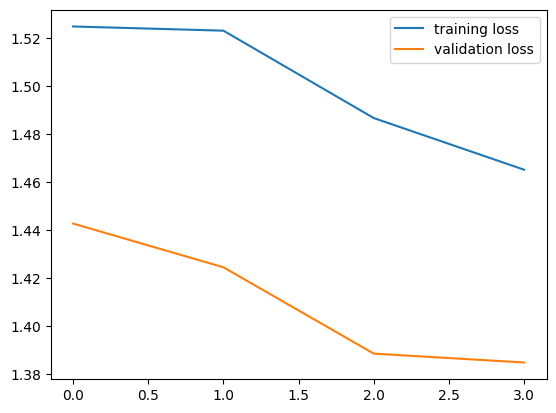

In [29]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(['training loss', 'validation loss'])
plt.show()

In [32]:
from google.colab import files

In [31]:
# Save the model

MODEL_NAME = "codesim_model.pth"
torch.save(model.state_dict(), MODEL_NAME)
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Notes

### Training results with different parameters:

| Pretrained Model |`T`| Model Structure | Epochs | Training Loss | Validation Loss |
| ---------- | - | --------------- | ------ | ------------- | --------------- |
| CodeBERTa Small v1 | 0.07 | TFM → mean pool → MLP w/ batchnorm | - | ~1.6 | - |
| CodeBERTa Small v1 | 0.07 | TFM → lin1 → lin2 → MLP w/ batchnorm → max pool | - | ~1.4 | - |
| CodeBERTa Small v1 | 0.50 | (frozen) TFM's pooler output → layernorm → lin1 → lin2 → MLP  | 6 |  ~1.5 | ~1.35 |

`T` is the temperature hyperparameter of the NTXent loss function.

### Data TODOs
- ❎ - A lot of codes snippets mined from github can't be minified, filter unlabeled code dataset!

### Model TODOs
- ❎ - Fine-tuning the transformer
- ❎ - Evaluation